In [79]:
import mlflow.pyfunc
from typing import Any, Dict, Union
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import shap

Things to cover in the 2nd article: 
1. Pipeline
    * preprocessing that need to be trained
    * model pipeline with switchable preprocessor
    * model explanation & visualization
2. Algorithm agnostic
    * the pipeline should be able to easily switch between algorithms & preprocessing logics
    * some complexities might need to be built-in for some component of the pipeline (say explanation) to ensure uniform API

Steps

1. The minimalist algorithm agnostic pipeline (Done)
    * ~~static preprocessing~~
    * ~~accept any model~~
    * ~~demo different algorithms~~
2. Pipeline with custom preprocesser (Done)
    * ~~custom preprocesser 1 for numeric features~~
    * ~~demo the pipeline~~
    * ~~customer preprocesser 2 that can handle categorical features too~~
    * ~~demo using the same pipeline but calling the advanced preprocesser~~
3. Add explainer


# The Minimalist Algorithm Agnostic Pipeline

* minimal preprocessing
* algorithm agnostic: can be used to experiment with any sklearn models

In [2]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    ML_PIPELINE is an implementation of an MLflow Python model that can be used with any 
    scikit-learn compatible model (e.g., XGBoost, LightGBM, etc.).
    This class includes methods for preprocessing input data, training the model, 
    and making predictions.

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance (initialized as None).
        config (Any or None): Optional configuration for the model (initialized as None).
    """

    def __init__(self, model: BaseEstimator = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with the given model and optional configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model (e.g., LightGBM, XGBoost).
            config (Any, optional): Optional configuration for the model.
        """
        self.model = model
        self.config = config

    def preprocess_input(self, model_input: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the input data by replacing missing values with 0.

        Parameters:
            model_input (pd.DataFrame): The input DataFrame to preprocess.

        Returns:
            pd.DataFrame: The preprocessed DataFrame with NaN values replaced by 0.
        """
        processed_input = model_input.copy()
        processed_input = processed_input.fillna(0)
        return processed_input


    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the preprocessed training data.

        Parameters:
            X_train (pd.DataFrame): The training input data (features).
            y_train (pd.Series): The target values for the training data.
        """
        X_train_preprocessed = self.preprocess_input(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(self, context: Any, model_input: pd.DataFrame) -> Any:
        """
        Make predictions using the trained model.

        Parameters:
            context (Any): Optional context provided by MLflow during the prediction phase.
            model_input (pd.DataFrame): The input data to predict on.

        Returns:
            Any: The predicted probabilities or results.
        """
        processed_model_input = self.preprocess_input(model_input.copy())
        return self.model.predict_proba(processed_model_input)[:,1]


In [3]:
# Create a synthetic dataset
n_feature = 10
n_inform = 4 
n_redundant = 3
n_samples = 1000
X, y = make_classification(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, n_redundant=n_redundant, shuffle=False, random_state=12)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## Train an XGBClassifier with the Pipeline

In [4]:
model = xgb.XGBClassifier()
ml_pipeline = ML_PIPELINE(model = model)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context = None, model_input = X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc}")

auc:0.9664966496649665


## Train a Random Forest Classifier with the Pipeline

In [5]:
params = {
    'n_estimators': 100,            
    'min_samples_split': 4,         
    'min_samples_leaf': 2,          
    'max_features': 'sqrt',         
    'bootstrap': True,              
    'random_state': 32             
}
model = RandomForestClassifier(**params)
ml_pipeline = ML_PIPELINE(model = model)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context = None, model_input = X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.968


## Train a LightGBM Classifier with the Pipeline

In [6]:
params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_data_in_leaf': 10,
    'random_state': 42
}
model = lgb.LGBMClassifier(**params, verbose = -1)
ml_pipeline = ML_PIPELINE(model = model)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context = None, model_input = X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.972


In [7]:
# extract the model from the pipeline, you don't need `context` parameter when making the prediction
print(f"auc: {roc_auc_score(y_test, ml_pipeline.model.predict_proba(X_test)[:,1]):.3f}")

auc: 0.972


In [8]:
# retrieve any particular parameters
ml_pipeline.model.learning_rate

0.1

In [9]:
# or all the parameter config
ml_pipeline.model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'min_data_in_leaf': 10,
 'verbose': -1}

In [10]:
print(f"The model is trained on {ml_pipeline.model._n_features} features, including {ml_pipeline.model.feature_name_}")

The model is trained on 10 features, including ['inf_1', 'inf_2', 'inf_3', 'inf_4', 'rand_5', 'rand_6', 'rand_7', 'rand_8', 'rand_9', 'rand_10']


# Pipeline with Preprocessing Logic

The above minimalist pipeline has very simple preprocessing logic that is not sufficient for most ML projects. To begin with, at least we need a scalar that can be 

### Create A Custome Preprocessor 

In [11]:
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    A custom preprocessor that handles scaling and imputation of numeric features.

    Attributes:
        transformer (Pipeline): Pipeline for scaling and imputing numeric data.
        features (List[str]): List of feature names from the input DataFrame.
    """

    def __init__(self):
        """
        Initializes the PreProcessor with a placeholder for the transformer pipeline.
        """
        self.transformer = None

    def fit(self, X, y=None):
        """
        Fits the transformer on the provided dataset by configuring scaling and imputing on numeric features.

        Parameters:
            X (pd.DataFrame): The input features to fit the transformer.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            PreProcessor: The fitted transformer instance.
        """
        self.features = X.columns.tolist()

        if self.features:
            self.transformer = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median'))
            ])
            self.transformer.fit(X[self.features])

        return self

    def transform(self, X):
        """
        Transforms the input data by applying the fitted scaling and imputing pipeline.

        Parameters:
            X (pd.DataFrame): The input features to transform.
        
        Returns:
            pd.DataFrame: The transformed data with scaled and imputed numeric features.
        """
        X_transformed = pd.DataFrame()

        if self.features:
            transformed_data = self.transformer.transform(X[self.features])
            X_transformed[self.features] = transformed_data

        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fits the transformer on the input data and then transforms it.

        Parameters:
            X (pd.DataFrame): The input features to fit and transform.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        self.fit(X, y)
        return self.transform(X)


### Utilize the Preprocessor in the PL Pipeline

Now let's utilize the preprocessor in the ML pipeline. 

In [12]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    ML_PIPELINE is an implementation of an MLflow Python model that can be used with any 
    scikit-learn compatible model (e.g., XGBoost, LightGBM, etc.).
    This class includes methods for preprocessing input data, training the model, 
    and making predictions.

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance (initialized as None).
        config (Any or None): Optional configuration for the model (initialized as None).
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with the given model and optional configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model (e.g., LightGBM, XGBoost).
            config (Any, optional): Optional configuration for the model.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the preprocessed training data.

        Parameters:
            X_train (pd.DataFrame): The training input data (features).
            y_train (pd.Series): The target values for the training data.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(self, context: Any, model_input: pd.DataFrame) -> Any:
        """
        Make predictions using the trained model.

        Parameters:
            context (Any): Optional context provided by MLflow during the prediction phase.
            model_input (pd.DataFrame): The input data to predict on.

        Returns:
            Any: The predicted probabilities or results.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        return self.model.predict_proba(processed_model_input)[:,1]

In [13]:
preprocessor = PreProcessor()
ml_pipeline = ML_PIPELINE(model = model, 
                          preprocessor=preprocessor)

In [14]:
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context=None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc: {auc:.3f}")

auc: 0.971


### Easily Migrate to a Different Preprocessor

The above preprocessor has some room for improvement. For one, it doesn't handle categorical features. Let's

* create a more sophisticated preprocessor with the same API
* test switching preprocessor  to the ML pipeline (we shouldn't need to change a single line in the ML Pipeline class)

In [15]:
class PreProcessor_v2(BaseEstimator, TransformerMixin):
    """
    A custom transformer that handles scaling of numeric data and encoding of categorical features.

    Attributes:
        num_transformer (Pipeline): Pipeline for transforming numerical features, including scaling and imputing.
        cat_transformer (Pipeline): Pipeline for transforming categorical features, including imputing and encoding.
        transformed_cat_cols (List[str]): List of transformed categorical column names after one-hot encoding.
        num_features (List[str]): List of numerical features to be transformed.
        cat_features (List[str]): List of categorical features to be transformed.
    """

    def __init__(self,num_impute_strategy = 'median',cat_impute_strategy = 'most_frequent'):
        """
        Initializes the CustomTransformer with attributes to store the transformers for numeric and categorical data.
        """
        self.num_transformer = None
        self.cat_transformer = None
        self.num_impute_strategy = num_impute_strategy
        self.cat_impute_strategy = cat_impute_strategy
        self.transformed_cat_cols = []

    def fit(self, X, y=None):
        """
        Fits the transformer on the provided dataset, configuring scaling and encoding as necessary.

        Parameters:
            X (pd.DataFrame): Input features for fitting the transformer.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            CustomTransformer: The fitted transformer instance.
        """
        self.num_features = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy=self.num_impute_strategy))
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=self.cat_impute_strategy)),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self

    def get_transformed_cat_cols(self):
        """
        Generates a list of transformed categorical column names after one-hot encoding.

        Returns:
            List[str]: List of one-hot encoded categorical column names.
        """
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols

    def transform(self, X):
        """
        Transforms the input data by applying scaling and encoding based on the fitted transformers.

        Parameters:
            X (pd.DataFrame): Input features to be transformed.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        X_transformed = pd.DataFrame()

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data, columns=self.transformed_cat_cols)
            X_transformed = pd.concat([X_transformed, transformed_cat_df], axis=1)
        
        X_transformed.index = X.index

        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fits the transformer and then applies the transformations to the input data.

        Parameters:
            X (pd.DataFrame): Input features for fitting and transforming.
            y (pd.Series, optional): Target variable, not used in this method.
        
        Returns:
            pd.DataFrame: The transformed data.
        """
        self.fit(X, y)
        return self.transform(X)

In [50]:
# create a synthetic dataset that contains categorical features, let's add some missings as well
n_feature = 10
n_inform = 4 
n_redundant = 3
n_samples = 1000
X, y = make_classification(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, n_redundant=n_redundant, shuffle=False, random_state=12)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)
# change X['inf_1] to categorical
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['bottom', 'lower-mid', 'upper-mid', 'top']
X['inf_1'] = pd.qcut(X['inf_1'], q=percentiles, labels=labels)
# add missings
np.random.seed(42) 
missing_rate = 0.20 
n_missing = int(np.floor(missing_rate * X.size))
missing_indices = (np.random.randint(0, X.shape[0], n_missing), 
                   np.random.randint(0, X.shape[1], n_missing)) 
X.values[missing_indices] = np.nan
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [58]:
# the new preprocessor works fine as it handles categorical features well
preprocessor_v2 = PreProcessor_v2()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.968


In [57]:
# The default numeric impute strategy is median
ml_pipeline.preprocessor.num_impute_strategy

'median'

In [60]:
# we can adjust parameter of the preprocessor, let's change the impute strategy
preprocessor_v2 = PreProcessor_v2(num_impute_strategy = 'mean')
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor = preprocessor_v2
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.968


In [61]:
ml_pipeline.preprocessor.num_impute_strategy

'mean'

In [62]:
# the first preprocessor which doesn't handle categorical features will error 
# with the new synthetic data
preprocessor = PreProcessor()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=preprocessor
)
ml_pipeline.fit(X_train, y_train)


ValueError: could not convert string to float: 'lower-mid'

In [65]:
# of course, you can still switch between models
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1 
}
model = xgb.XGBClassifier(**params)
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")


auc:0.968


# Explain the Model

Now the model pipeline contains a preprocessor to preprocess the data for the model. Let's add an explainer to explain the model. 

In [73]:
class ML_PIPELINE(mlflow.pyfunc.PythonModel):
    """
    ML_PIPELINE is an implementation of an MLflow Python model that can be used with any 
    scikit-learn compatible model (e.g., XGBoost, LightGBM, etc.).
    This class includes methods for preprocessing input data, training the model, 
    and making predictions.

    Attributes:
        model (BaseEstimator or None): A scikit-learn compatible model instance (initialized as None).
        config (Any or None): Optional configuration for the model (initialized as None).
    """

    def __init__(self, model: BaseEstimator = None, preprocessor = None, config: Any = None):
        """
        Initialize the ML_PIPELINE with the given model and optional configuration.

        Parameters:
            model (BaseEstimator, optional): A scikit-learn compatible model (e.g., LightGBM, XGBoost).
            config (Any, optional): Optional configuration for the model.
        """
        self.model = model
        self.preprocessor = preprocessor
        self.config = config

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """
        Train the model using the preprocessed training data.

        Parameters:
            X_train (pd.DataFrame): The training input data (features).
            y_train (pd.Series): The target values for the training data.
        """
        X_train_preprocessed = self.preprocessor.fit_transform(X_train.copy())
        self.model.fit(X_train_preprocessed, y_train)

    def predict(self, context: Any, model_input: pd.DataFrame) -> Any:
        """
        Make predictions using the trained model.

        Parameters:
            context (Any): Optional context provided by MLflow during the prediction phase.
            model_input (pd.DataFrame): The input data to predict on.

        Returns:
            Any: The predicted probabilities or results.
        """
        processed_model_input = self.preprocessor.transform(model_input.copy())
        return self.model.predict_proba(processed_model_input)[:,1]
    
    def explain_model(self,X):
        X_transformed = self.preprocessor.transform(X.copy())
        self.X_explain = X_transformed.copy()
        self.X_explain.reset_index(drop=True)
        explainer = shap.Explainer(self.model)
        self.shap_values = explainer(X_transformed)  
        try:
            self.shap_values.values.shape[2] 
            self.both_class = True
        except:
            self.both_class = False
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        if self.shap_values is None:
            print("pls explain model first")
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1])

In [82]:
# Train the new model pipeline with the explainer ability
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
y_prob = ml_pipeline.predict(context= None, model_input=X_test)
auc = roc_auc_score(y_test, y_prob)
print(f"auc:{auc:.3f}")

auc:0.968


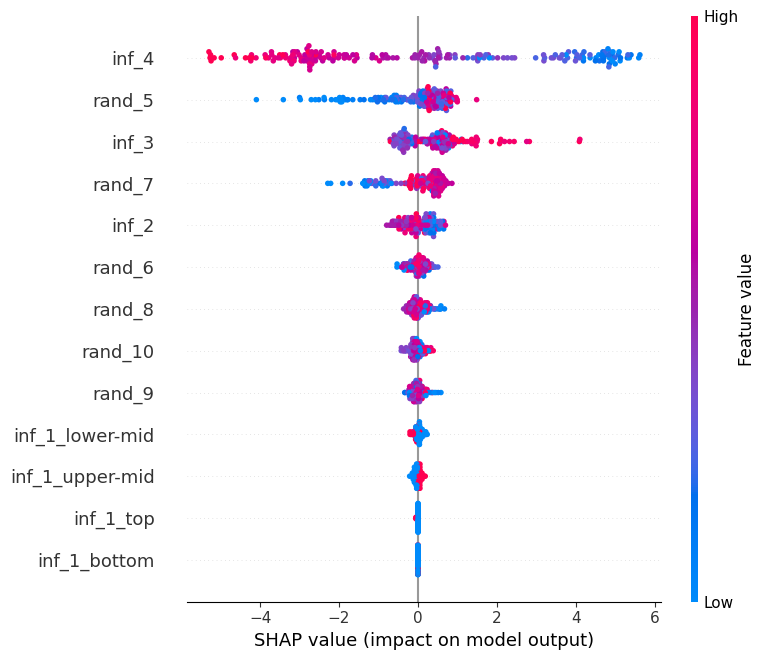

In [83]:
ml_pipeline.explain_model(X_test)

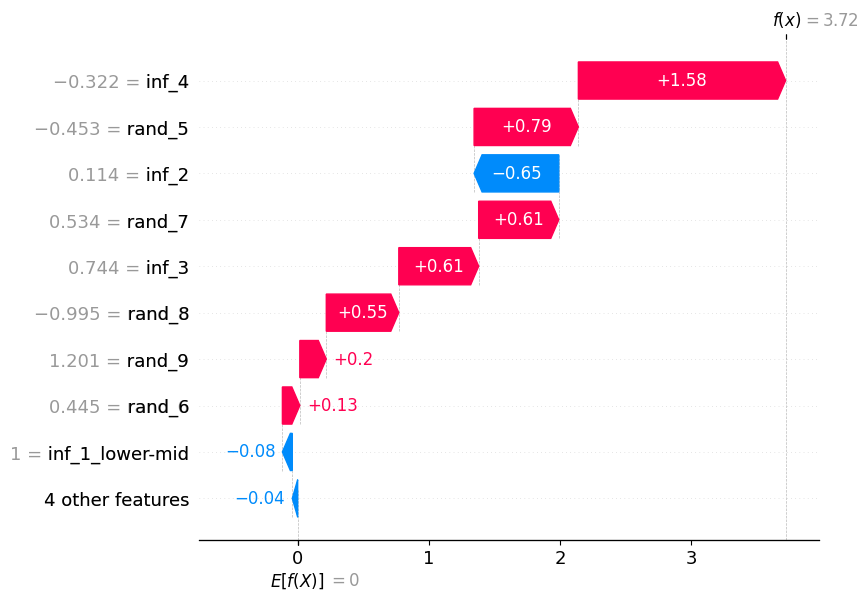

In [78]:
case_number = 1
ml_pipeline.explain_case(case_number)

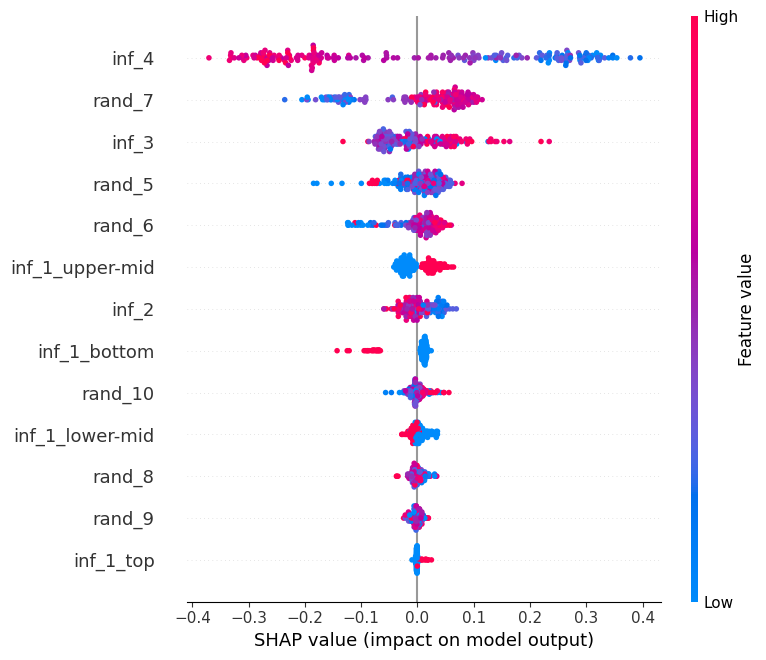

In [86]:
# This pipeline is algorithm agnostic
model = RandomForestClassifier()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
ml_pipeline.explain_model(X_test)

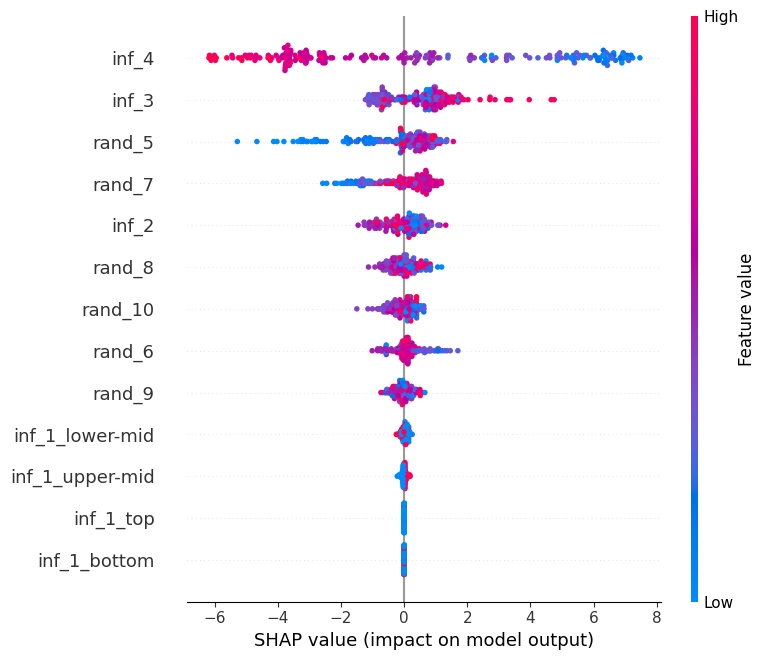

In [87]:
# This pipeline is algorithm agnostic
model = xgb.XGBClassifier()
ml_pipeline = ML_PIPELINE(
    model = model, 
    preprocessor=PreProcessor_v2()
)
ml_pipeline.fit(X_train, y_train)
ml_pipeline.explain_model(X_test)